In [1]:
import pandas as pd
import konlpy
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sentencepiece as spm
from keras.callbacks import EarlyStopping

2024-12-12 07:55:57.118615: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 07:55:57.136846: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-12 07:55:57.136863: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-12 07:55:57.136874: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 07:55:57.140511: I tensorflow/core/platform/cpu_feature_g

# 데이터 불러오기

In [2]:
# 데이터를 읽어봅시다.
train_data = pd.read_table('./data/ratings_train.txt')
test_data = pd.read_table('./data/ratings_test.txt')

print('전체 데이터 개수 :', len(train_data))
train_data.head()

전체 데이터 개수 : 150000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 전처리

전처리 : 결측치, 중복 데이터 제거

In [3]:
# 중복 및 결측치 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
train_data = train_data.dropna(how='any')
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data = test_data.dropna(how='any')

print('train 데이터 사이즈:', len(train_data))
print('test 데이터 사이즈:', len(test_data))

train 데이터 사이즈: 146182
test 데이터 사이즈: 49157


In [4]:
data = list(train_data['document'])

문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


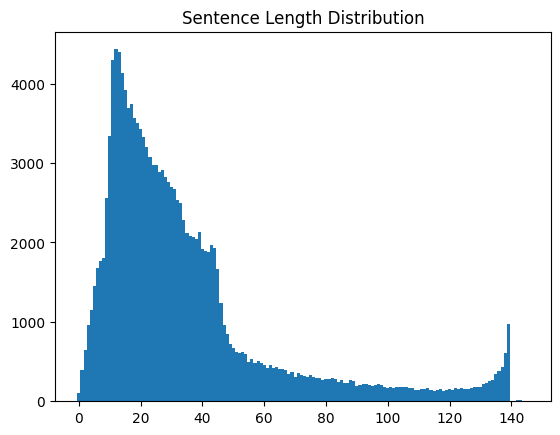

In [5]:
# 문장의 최단 길이, 최장 길이, 평균 길이를 구한 후 문장 길이분포를 막대그래프로 표현해주는 소스
min_len = 999
max_len = 0
sum_len = 0

for sen in data:
    length = len(sen)
    if min_len > length:
        min_len = length
    if max_len < length:
        max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(data))

sentence_length = np.zeros((max_len), dtype=np.int64)

for sen in data:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [6]:
# 길이 체크 함수로 문장 길이 확인하기
def check_sentence_with_length(raw, length):
    count = 0

    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100:
                return
# 훈련 데이터 길이가 1인 문장 확인해보기
check_sentence_with_length(data, 1)

아
잼
1
4
굿
짱
휴
.
음
?
ㅎ
ㅋ
즐
♥
굳
네
ㅇ
k
ㅠ
쒯
♬
토
O
똥
z
헐
삼
꽝
!
풉
ㅅ
왜
ㄴ
쉣
봐
뿌
ㅜ
♡
ㅁ
0
ㅉ
d
흥
乃
찜
귯
린
시
ㅗ
a
c
흠
웅
ㅣ
오
9
쩜
애
헝
쨩
f
움
ㄳ
업
헉
군
b
;
g
올
걍
허
-
쀍
로
ㄹ
ㅂ
갑
즛
킥
함
진
ㅡ
잠
곧
ㅍ
h
·
캬
ㅆ
,
풋
ㄱ
파
ㄷ
웩
꺅
욜
ㅄ
2
핡


In [7]:
# 훈련 데이터 길이가 2인 문장 확인해보기
check_sentence_with_length(data, 2)
print("-------------------------------------")

최고
졸작
대박
버려
망함
굳굳
안습
망작
ㅇㅇ
쵝오
굿!
별루
씐나
쓰렉
볼만
허접
비추
좋다
ㅎㅎ
아나
ㅉㅉ
야.
역시
^^
오오
평이
지루
오욈
ㅋㅋ
지송
별로
눈물
당연
쩔어
별노
몰입
졸잼
돋네
오글
이응
첨봄
최악
잼씀
ok
유후
감동
gg
;;
조앙
1점
표절
명작
으휴
에효
ㄱ굿
굿잡
잼나
10
ㅜㅜ
우왕
거지
굿굿
좋음
실망
굿.
애이
짱임
전설
mm
와우
등록
하위
그닥
뭉클
삼류
HN
윤하
섹시
실화
머냐
수작
꿀잼
동감
dd
굳ㅋ
굳!
추천
좋아
55
안봐
개쩜
올레
난해
ㅠㅠ
뭐니
ㅁㅁ
뭥미
쓰랙
좇~
오우
미안
-------------------------------------


전처리 : 최대, 최소 문장 길이 지정

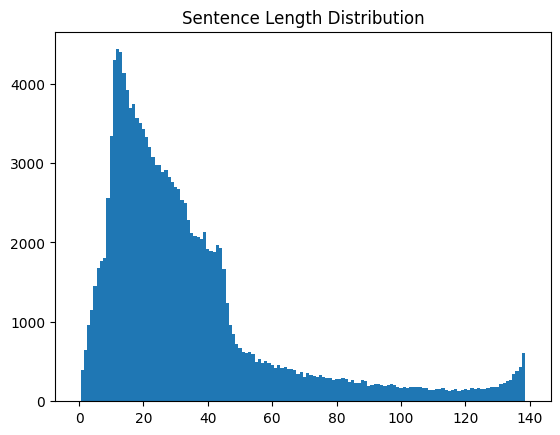

In [8]:
max_len = 140
min_len = 2

# 길이 조건에 맞는 문장만 선택
filtered_corpus = [s for s in data if (
    len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려보자
# 아래 나온 그래프는 최종 데이터 분포
sentence_length = np.zeros((max_len), dtype=np.int64)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

# SentencePiece 적용

In [9]:
temp_file = '/workspace/aiffel/sentence_piece/data/ratings_train.temp'
vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in train_data['document']:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')

# 'unigram'
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=naver_review_spm --vocab_size={}'.format(temp_file, vocab_size)    
)

# 'bpe'
spm.SentencePieceTrainer.Train(
    '--input={} --model_type=bpe --model_prefix=naver_review_spm_bpe --vocab_size={}'.format(temp_file, vocab_size)    
)

!ls -l naver_review_spm*

-rw-r--r-- 1 root root 375088 Dec 12 07:56 naver_review_spm.model
-rw-r--r-- 1 root root 144478 Dec 12 07:56 naver_review_spm.vocab
-rw-r--r-- 1 root root 370183 Dec 12 07:56 naver_review_spm_bpe.model
-rw-r--r-- 1 root root 115389 Dec 12 07:56 naver_review_spm_bpe.vocab


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=/workspace/aiffel/sentence_piece/data/ratings_train.temp --model_prefix=naver_review_spm --vocab_size=8000
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: /workspace/aiffel/sentence_piece/data/ratings_train.temp
  input_format: 
  model_prefix: naver_review_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file:

Unigram

In [10]:
# sentencepiece 모델이 잘 적용됐는지 확인해보기
s_uni = spm.SentencePieceProcessor()
s_uni.Load('naver_review_spm.model')  # unigram 타입 model

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s_uni.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s_uni.SampleEncodeAsPieces('아버지가방에들어가신다.'))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s_uni.DecodeIds(tokensIDs))

[1405, 9, 396, 15, 1285, 9, 118, 17, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


Bpe

In [11]:
# sentencepiece 모델이 잘 적용됐는지 확인해보기
s_bpe = spm.SentencePieceProcessor()
s_bpe.Load('naver_review_spm_bpe.model')  # bpe 타입 model

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s_bpe.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s_bpe.SampleEncodeAsPieces('아버지가방에들어가신다.'))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s_bpe.DecodeIds(tokensIDs))

[4856, 884, 6552, 6300, 1411, 6296, 6396, 6290, 6288]
['▁아버', '지가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


# 토큰화 함수 sp_tokenize() 구현

In [12]:
def sp_tokenize(s, corpus, unigram):
    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    if unigram == True:
        with open("./naver_review_spm.vocab", 'r') as f:  # unigram 타입 vocab
            vocab = f.readlines()
    else:
        with open("./naver_review_spm_bpe.vocab", 'r') as f:  # bpe 타입 vocab
            vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx: word})
        index_word.update({word: idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(
        tensor, padding='pre', maxlen=100)

    return tensor, word_index, index_word

# 학습 데이터, 검증 데이터, 테스트 데이터 분리

In [13]:
X_train_uni, word_index_uni, index_word_uni = sp_tokenize(s_uni, data, True)
X_train_bpe, word_index_bpe, index_word_bpe = sp_tokenize(s_bpe, data, False)
X_test_uni, _, _ = sp_tokenize(s_uni, test_data['document'], True)
X_test_bpe, _, _ = sp_tokenize(s_bpe, test_data['document'], False)

y_train_sentence = np.array(list(train_data['label']))
y_test_sentence = np.array(list(test_data['label']))

# validation set 50000건 분리
X_val_uni = X_train_uni[:50000]
X_val_bpe = X_train_bpe[:50000]
y_val_sentence = y_train_sentence[:50000]

# validation set을 제외한 나머지
partial_X_train_uni = X_train_uni[50000:]
partial_X_train_bpe = X_train_bpe[50000:]
partial_y_train_sentence = y_train_sentence[50000:]

print(partial_X_train_uni.shape)
print(partial_X_train_bpe.shape)
print(partial_y_train_sentence.shape)

(96182, 100)
(96182, 100)
(96182,)


# 자연어 처리 모델 정의

In [14]:
early_stopping = EarlyStopping(
    monitor='val_loss',   # 평가 기준 메트릭
    patience=3,           # 개선되지 않는 에포크 수
    verbose=1,            # 진행 상태 출력
    restore_best_weights=True  # 최적 가중치 복원
)

def build_model(vocab_size, word_vector_dim):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(
        vocab_size, word_vector_dim, input_shape=(None,)))
    model.add(tf.keras.layers.LSTM(16))
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model

In [15]:
vocab_size = 8000
word_vector_dim = 128

model_uni = build_model(vocab_size, word_vector_dim)
model_uni.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


model_bpe = build_model(vocab_size, word_vector_dim)
model_bpe.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

epochs = 10 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.

history_uni = model_uni.fit(partial_X_train_uni,
                            partial_y_train_sentence,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(X_val_uni, y_val_sentence),
                        verbose=1)

history_bpe = model_bpe.fit(partial_X_train_bpe,
                            partial_y_train_sentence,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(X_val_bpe, y_val_sentence),
                        verbose=1)

2024-12-12 07:56:15.791866: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-12-12 07:56:15.791878: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: 11be54d0c487
2024-12-12 07:56:15.791880: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: 11be54d0c487
2024-12-12 07:56:15.791931: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.183.1
2024-12-12 07:56:15.791936: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.183.1
2024-12-12 07:56:15.791938: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.183.1


Epoch 1/10
188/188 [==============================] - 8s 38ms/step - loss: 0.5261 - accuracy: 0.7593 - val_loss: 0.3783 - val_accuracy: 0.8437
Epoch 2/10
188/188 [==============================] - 7s 37ms/step - loss: 0.3380 - accuracy: 0.8568 - val_loss: 0.3418 - val_accuracy: 0.8520
Epoch 3/10
188/188 [==============================] - 7s 37ms/step - loss: 0.2974 - accuracy: 0.8755 - val_loss: 0.3361 - val_accuracy: 0.8511
Epoch 4/10
188/188 [==============================] - 7s 37ms/step - loss: 0.2689 - accuracy: 0.8874 - val_loss: 0.3418 - val_accuracy: 0.8537
Epoch 5/10
188/188 [==============================] - 7s 37ms/step - loss: 0.2402 - accuracy: 0.8996 - val_loss: 0.3517 - val_accuracy: 0.8519
Epoch 6/10
188/188 [==============================] - 7s 37ms/step - loss: 0.2147 - accuracy: 0.9119 - val_loss: 0.3818 - val_accuracy: 0.8500
Epoch 7/10
188/188 [==============================] - 7s 37ms/step - loss: 0.1912 - accuracy: 0.9217 - val_loss: 0.4177 - val_accuracy: 0.8470

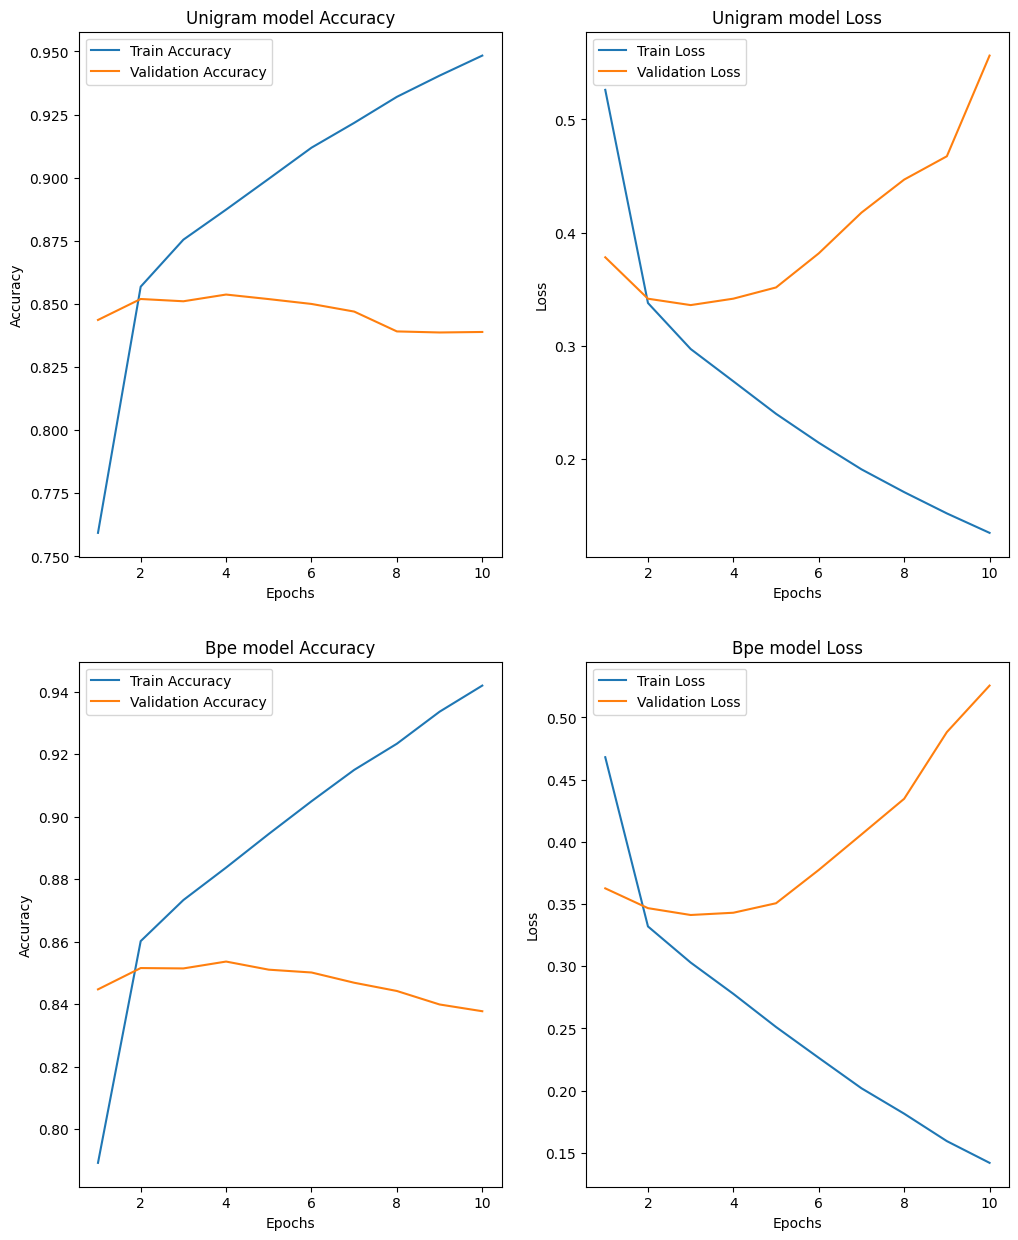

In [16]:
import matplotlib.pyplot as plt

acc1 = history_uni.history['accuracy']
val_acc1 = history_uni.history['val_accuracy']
loss1 = history_uni.history['loss']
val_loss1 = history_uni.history['val_loss']
acc2 = history_bpe.history['accuracy']
val_acc2 = history_bpe.history['val_accuracy']
loss2 = history_bpe.history['loss']
val_loss2 = history_bpe.history['val_loss']

epochs = range(1, len(acc1) + 1)

# Figure 생성 (3행 2열)
fig, axes = plt.subplots(2, 2, figsize=(12, 15))

# Plot 1: uni Accuracy
axes[0, 0].plot(epochs, acc1, label='Train Accuracy')
axes[0, 0].plot(epochs, val_acc1, label='Validation Accuracy')
axes[0, 0].set_title('Unigram model Accuracy')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()

# Plot 2: uni Loss
axes[0, 1].plot(epochs, loss1, label='Train Loss')
axes[0, 1].plot(epochs, val_loss1, label='Validation Loss')
axes[0, 1].set_title('Unigram model Loss')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()

# Plot 3: bpe Accuracy
axes[1, 0].plot(epochs, acc2, label='Train Accuracy')
axes[1, 0].plot(epochs, val_acc2, label='Validation Accuracy')
axes[1, 0].set_title('Bpe model Accuracy')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()

# Plot 4: bpe Loss
axes[1, 1].plot(epochs, loss2, label='Train Loss')
axes[1, 1].plot(epochs, val_loss2, label='Validation Loss')
axes[1, 1].set_title('Bpe model Loss')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()

plt.show()

# Konlpy 형태소 분석기와의 성능 비교

In [17]:
from konlpy.tag import Mecab
from collections import Counter

tokenizer = Mecab()
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘',
             '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']


def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how='any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how='any')

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)  # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)  # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word: index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index


train_data = pd.read_table('./data/ratings_train.txt')
test_data = pd.read_table('./data/ratings_test.txt')
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [18]:
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3
index_to_word = {index: word for word, index in word_to_index.items()}

In [19]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다.
def get_decoded_sentence(encoded_sentence, index_to_word):
    # [1:]를 통해 <BOS>를 제외
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [20]:
total_data_text = list(X_train)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(
    f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.9831648219343
문장길이 최대 :  116
문장길이 표준편차 :  12.824914881885917
pad_sequences maxlen :  41
전체 문장의 0.9341300570521679%가 maxlen 설정값 이내에 포함됩니다. 


In [21]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post',  # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post',  # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [22]:
# validation set 29236건 분리
X_val = X_train[:29236]
y_val = y_train[:29236]

# validation set을 제외한 나머지
partial_X_train = X_train[29236:]
partial_y_train = y_train[29236:]

print(partial_X_train.shape)
print(partial_y_train.shape)
print(X_val.shape)
print(y_val.shape)

(116946, 41)
(116946,)
(29236, 41)
(29236,)


In [23]:
vocab_size = len(index_to_word)    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 128  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)
# maxlen : 문장 최대길이

In [24]:
model_mecab = build_model(vocab_size, word_vector_dim)

In [25]:
model_mecab.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
epochs = 10

history_mecab = model_mecab.fit(partial_X_train,
                            partial_y_train,
                            epochs=epochs,
                            batch_size=512,
                            validation_data=(X_val, y_val),
                            verbose=1)

Epoch 1/10


229/229 [==============================] - 4s 16ms/step - loss: 0.5779 - accuracy: 0.6897 - val_loss: 0.4612 - val_accuracy: 0.8162
Epoch 2/10
229/229 [==============================] - 3s 15ms/step - loss: 0.3818 - accuracy: 0.8422 - val_loss: 0.3505 - val_accuracy: 0.8481
Epoch 3/10
229/229 [==============================] - 3s 15ms/step - loss: 0.3185 - accuracy: 0.8660 - val_loss: 0.3455 - val_accuracy: 0.8509
Epoch 4/10
229/229 [==============================] - 3s 15ms/step - loss: 0.2925 - accuracy: 0.8777 - val_loss: 0.3463 - val_accuracy: 0.8525
Epoch 5/10
229/229 [==============================] - 3s 15ms/step - loss: 0.2692 - accuracy: 0.8857 - val_loss: 0.3611 - val_accuracy: 0.8517
Epoch 6/10
229/229 [==============================] - 3s 15ms/step - loss: 0.2481 - accuracy: 0.8943 - val_loss: 0.3741 - val_accuracy: 0.8534
Epoch 7/10
229/229 [==============================] - 3s 15ms/step - loss: 0.2298 - accuracy: 0.9017 - val_loss: 0.3869 - val_accuracy: 0.8526
Epoch 8/10

# 각 모델 별 Epoch간 Loss, Accuracy 비교

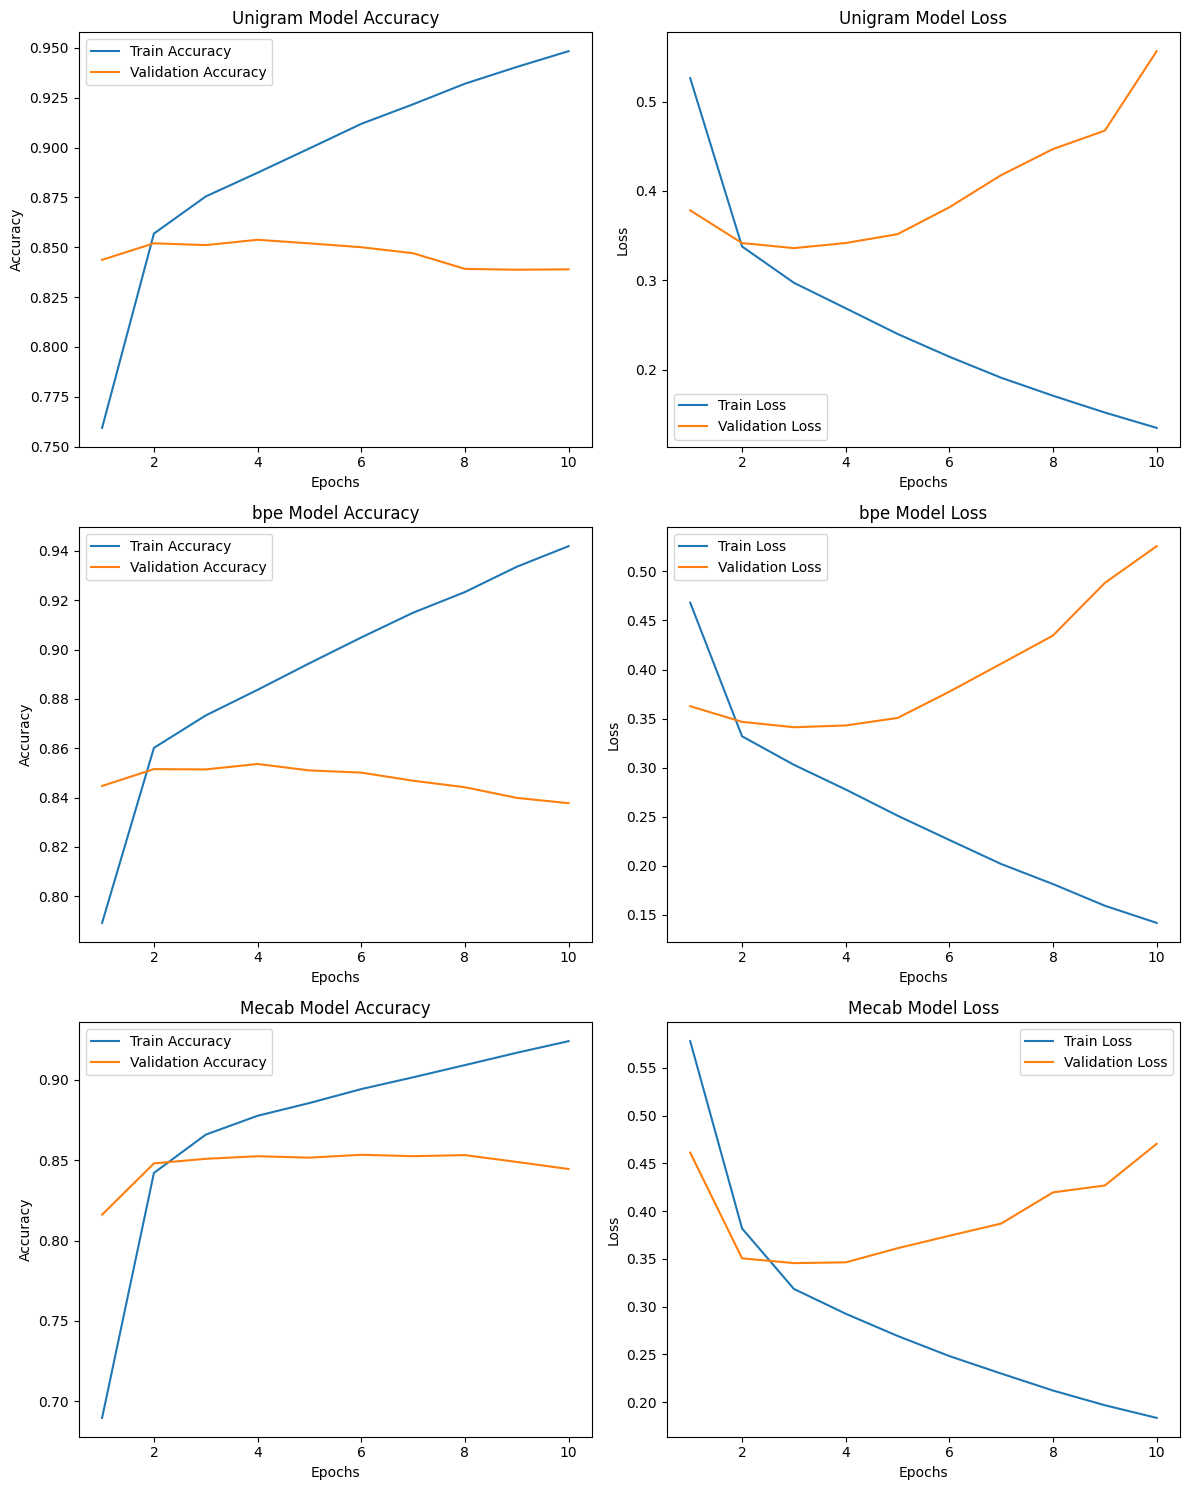

In [26]:
acc1 = history_uni.history['accuracy']
val_acc1 = history_uni.history['val_accuracy']
loss1 = history_uni.history['loss']
val_loss1 = history_uni.history['val_loss']
acc2 = history_bpe.history['accuracy']
val_acc2 = history_bpe.history['val_accuracy']
loss2 = history_bpe.history['loss']
val_loss2 = history_bpe.history['val_loss']
acc3 = history_mecab.history['accuracy']
val_acc3 = history_mecab.history['val_accuracy']
loss3 = history_mecab.history['loss']
val_loss3 = history_mecab.history['val_loss']

epochs = range(1, len(acc1) + 1)

# Figure 생성 (3행 2열)
fig, axes = plt.subplots(3, 2, figsize=(12, 15))

# Plot 1: Model 1 Accuracy
axes[0, 0].plot(epochs, acc1, label='Train Accuracy')
axes[0, 0].plot(epochs, val_acc1, label='Validation Accuracy')
axes[0, 0].set_title('Unigram Model Accuracy')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()

# Plot 2: Model 1 Loss
axes[0, 1].plot(epochs, loss1, label='Train Loss')
axes[0, 1].plot(epochs, val_loss1, label='Validation Loss')
axes[0, 1].set_title('Unigram Model Loss')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()

# Plot 3: Model 2 Accuracy
axes[1, 0].plot(epochs, acc2, label='Train Accuracy')
axes[1, 0].plot(epochs, val_acc2, label='Validation Accuracy')
axes[1, 0].set_title('bpe Model Accuracy')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()

# Plot 4: Model 2 Loss
axes[1, 1].plot(epochs, loss2, label='Train Loss')
axes[1, 1].plot(epochs, val_loss2, label='Validation Loss')
axes[1, 1].set_title('bpe Model Loss')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()

# Plot 5: Model 3 Accuracy
axes[2, 0].plot(epochs, acc3, label='Train Accuracy')
axes[2, 0].plot(epochs, val_acc3, label='Validation Accuracy')
axes[2, 0].set_title('Mecab Model Accuracy')
axes[2, 0].set_xlabel('Epochs')
axes[2, 0].set_ylabel('Accuracy')
axes[2, 0].legend()

# Plot 6: Model 3 Loss
axes[2, 1].plot(epochs, loss3, label='Train Loss')
axes[2, 1].plot(epochs, val_loss3, label='Validation Loss')
axes[2, 1].set_title('Mecab Model Loss')
axes[2, 1].set_xlabel('Epochs')
axes[2, 1].set_ylabel('Loss')
axes[2, 1].legend()

# Layout 조정 및 출력
plt.tight_layout()
plt.show()

# Ealry Stopping으로 overfitting 억제 후 정확도 비교

In [27]:
epochs = 20

vocab_size = 8000
word_vector_dim = 128

model_uni = build_model(vocab_size, word_vector_dim)
model_uni.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
history_uni = model_uni.fit(partial_X_train_uni,
                            partial_y_train_sentence,
                            epochs=epochs,
                            batch_size=512,
                            callbacks=[early_stopping],
                            validation_data=(X_val_uni, y_val_sentence),
                            verbose=1)

model_bpe = build_model(vocab_size, word_vector_dim)
model_bpe.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

history_bpe = model_bpe.fit(partial_X_train_bpe,
                            partial_y_train_sentence,
                            epochs=epochs,
                            batch_size=512,
                            callbacks=[early_stopping],
                            validation_data=(X_val_bpe, y_val_sentence),
                            verbose=1)

vocab_size = len(index_to_word)

model_mecab = build_model(vocab_size, word_vector_dim)
model_mecab.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

history_mecab = model_mecab.fit(partial_X_train,
                                partial_y_train,
                                epochs=epochs,
                                batch_size=512,
                                callbacks=[early_stopping],
                                validation_data=(X_val, y_val),
                                verbose=1)

Epoch 1/20
188/188 [==============================] - 8s 38ms/step - loss: 0.4759 - accuracy: 0.7886 - val_loss: 0.3585 - val_accuracy: 0.8473
Epoch 2/20
188/188 [==============================] - 7s 37ms/step - loss: 0.3273 - accuracy: 0.8624 - val_loss: 0.3410 - val_accuracy: 0.8516
Epoch 3/20
188/188 [==============================] - 7s 37ms/step - loss: 0.2934 - accuracy: 0.8790 - val_loss: 0.3394 - val_accuracy: 0.8509
Epoch 4/20
188/188 [==============================] - 7s 37ms/step - loss: 0.2690 - accuracy: 0.8899 - val_loss: 0.3438 - val_accuracy: 0.8519
Epoch 5/20
188/188 [==============================] - 7s 37ms/step - loss: 0.2476 - accuracy: 0.8990 - val_loss: 0.3550 - val_accuracy: 0.8513
Epoch 6/20
188/188 [==============================] - 7s 37ms/step - loss: 0.2260 - accuracy: 0.9079 - val_loss: 0.3715 - val_accuracy: 0.8461
Epoch 6: early stopping
Epoch 1/20
188/188 [==============================] - 8s 38ms/step - loss: 0.4728 - accuracy: 0.7905 - val_loss: 0.359

In [28]:
results_uni = model_uni.evaluate(X_test_uni, y_test, verbose=2)
results_bpe = model_bpe.evaluate(X_test_bpe, y_test, verbose=2)
results_mecab = model_mecab.evaluate(X_test, y_test, verbose=2)

1537/1537 - 3s - loss: 0.3481 - accuracy: 0.8460 - 3s/epoch - 2ms/step
1537/1537 - 3s - loss: 0.3509 - accuracy: 0.8473 - 3s/epoch - 2ms/step
1537/1537 - 1s - loss: 0.3510 - accuracy: 0.8463 - 1s/epoch - 927us/step


In [29]:
print('Unigram Model : ', results_uni[1])
print('Bpe Model : ', results_bpe[1])
print('Mecab Model : ', results_mecab[1])

Unigram Model :  0.8460035920143127
Bpe Model :  0.8473462462425232
Mecab Model :  0.8463494777679443


# 회고

처음에 잘 못 토큰화해서 정확도가 자꾸 50%나왔는데, 문제를 잘 찾아서 마무리할 수 있던 것 같음    
다행이다 ㅎㅎ